In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

In [ ]:
from n_framework import*
from activations_module import *

In [ ]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
     

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255

content_imgae_shape: torch.Size([3, 256, 256])


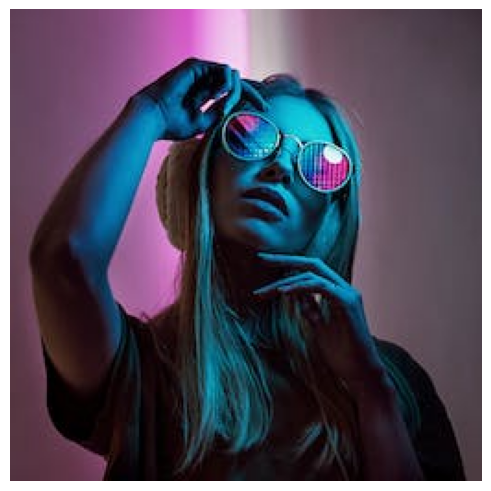

In [ ]:
content_img = download_image(face_url).to(def_device)
print('content_imgae_shape:',content_img.shape)
show_image(content_img);

In [ ]:
content_img.min(), content_img.max()

(tensor(0., device='mps:0'), tensor(1., device='mps:0'))

## optimizing an Image

In [ ]:
class LenghtDataset():
    def __init__(self, length=1): self.length = length
    def __len__(self): return self.length
    def __getitem__(self,idx): return 0,0
    
def getDummy_dls(length=100):
    return DataLoaders(DataLoader(LenghtDataset(length), batch_size=1), # train
                      DataLoader(LenghtDataset(1), batch_size=1)) # val,length=1

In [ ]:
# for batch in getDummy_dls(10).train:
#     print(batch)

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

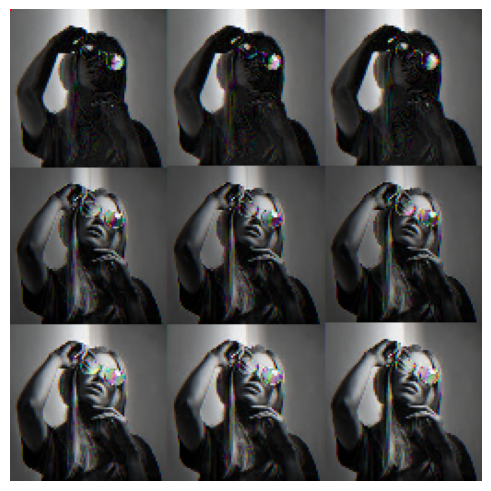

In [ ]:
class TensorModel2(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t
     

model = TensorModel2(torch.rand_like(content_img))
show_image(model());
     

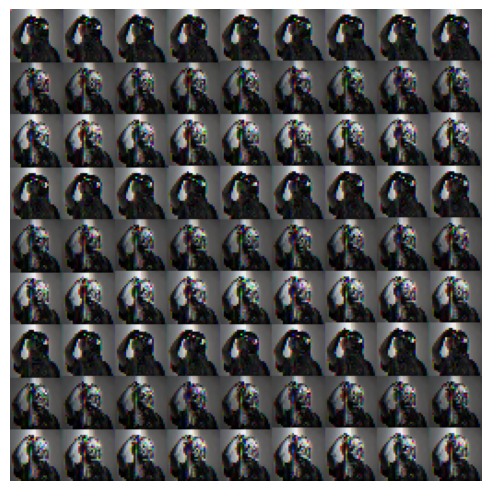

In [ ]:
model = TensorModel(torch.randn_like(content_img))
show_image(model());

In [ ]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self,learn): learn.preds = learn.model()
    def get_loss(self,learn): learn.loss = learn.loss_func(learn.preds)

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_img)

model = TensorModel(torch.rand_like(content_img))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(),DeviceCB()]
learn = Learner(model, getDummy_dls(100), loss_fn_mse,
                lr= 1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

loss,epoch,train
0.084,0,train
0.084,0,eval


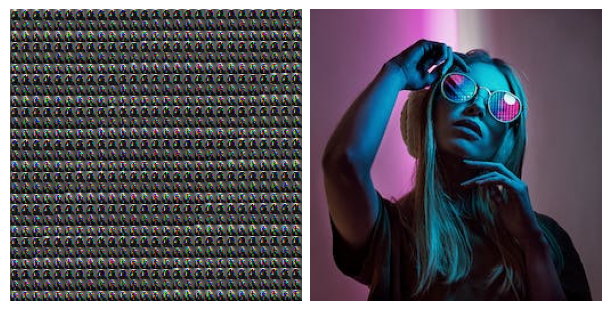

In [ ]:
show_images([learn.model().clip(0,1), content_img]);

###### lets view the progress

In [ ]:
class ImageLogCB(callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr();self.images=[]; self.i =0
    def after_batch(self, learn):
        if self.i%self.log_every ==0: self.images.append(to_cpu(learn.preds.clip(0,1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

In [ ]:
model = TensorModel(torch.rand_like(content_img))
learn = Learner(model, getDummy_dls(150), loss_fn_mse, lr=1e-2, cbs = cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs= [ImageLogCB(30)])